In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import mutual_info_classif
import warnings
import requests
import os

warnings.filterwarnings('ignore')

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator


In [2]:
class HeartDiseaseBayesianNetwork:
    def __init__(self):
        self.model = None
        self.inference = None
        self.data = None
        self.feature_names = [
            'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
            'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
        ]
        self.feature_descriptions = {
            'age': 'Age of the patient',
            'sex': 'Sex (1 = male, 0 = female)',
            'cp': 'Chest pain type (0–3)',
            'trestbps': 'Resting blood pressure',
            'chol': 'Serum cholesterol (mg/dl)',
            'fbs': 'Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)',
            'restecg': 'Resting ECG results (0–2)',
            'thalach': 'Maximum heart rate achieved',
            'exang': 'Exercise-induced angina (1 = yes; 0 = no)',
            'oldpeak': 'ST depression induced by exercise',
            'slope': 'Slope of the peak exercise ST segment',
            'ca': 'Number of major vessels (0–3) colored by fluoroscopy',
            'thal': 'Thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)',
            'target': 'Presence of heart disease (1 = yes; 0 = no)'
        }

    # -------------------------
    # Dataset Handling
    # -------------------------
    def download_dataset(self):
        """Download the UCI Cleveland dataset or create synthetic data if download fails."""
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
        local_file = "heart_disease.csv"

        try:
            if not os.path.exists(local_file):
                print("Downloading dataset...")
                response = requests.get(url, timeout=10)
                response.raise_for_status()

                with open(local_file, "w") as f:
                    f.write(response.text)

            # Load dataset
            column_names = self.feature_names
            df = pd.read_csv(local_file, names=column_names)

            # Replace missing values marked as '?'
            df.replace("?", np.nan, inplace=True)
            df.dropna(inplace=True)

            # Convert to numeric
            for col in df.columns:
                df[col] = pd.to_numeric(df[col])

            # Binarize target (0 = no disease, 1 = disease)
            df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

            self.data = df
            print(f"Dataset loaded successfully with {df.shape[0]} records.")
            return df

        except Exception as e:
            print("⚠️ Dataset download failed. Creating synthetic dataset instead.")
            return self.create_realistic_dataset()

    def create_realistic_dataset(self, n_samples=1000):
        """Create synthetic dataset if real one is unavailable."""
        np.random.seed(42)
        df = pd.DataFrame({
            'age': np.random.randint(29, 77, n_samples),
            'sex': np.random.choice([0, 1], n_samples),
            'cp': np.random.choice([0, 1, 2, 3], n_samples),
            'trestbps': np.random.randint(94, 200, n_samples),
            'chol': np.random.randint(126, 564, n_samples),
            'fbs': np.random.choice([0, 1], n_samples),
            'restecg': np.random.choice([0, 1, 2], n_samples),
            'thalach': np.random.randint(71, 202, n_samples),
            'exang': np.random.choice([0, 1], n_samples),
            'oldpeak': np.round(np.random.uniform(0, 6.2, n_samples), 1),
            'slope': np.random.choice([0, 1, 2], n_samples),
            'ca': np.random.choice([0, 1, 2, 3], n_samples),
            'thal': np.random.choice([1, 2, 3], n_samples),
            'target': np.random.choice([0, 1], n_samples, p=[0.45, 0.55])
        })
        self.data = df
        print(f"Synthetic dataset created with {df.shape[0]} records.")
        return df

    # -------------------------
    # EDA
    # -------------------------
    def explore_data(self, df):
        """Perform exploratory data analysis (EDA)."""
        print("Dataset Info:")
        print(df.info())
        print("\nMissing values:\n", df.isnull().sum())
        print("\nClass distribution:\n", df['target'].value_counts())

        plt.figure(figsize=(6, 4))
        sns.countplot(x='target', data=df, palette="Set2")
        plt.title("Heart Disease Distribution")
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
        plt.title("Feature Correlation Heatmap")
        plt.show()

    # -------------------------
    # Preprocessing
    # -------------------------
    def preprocess_data(self, df):
        """Discretize continuous variables for Bayesian Network."""
        df_processed = df.copy()
        df_processed['age_group'] = pd.cut(df['age'], bins=[28, 40, 55, 77], labels=['young', 'middle', 'old'])
        df_processed['bp_category'] = pd.cut(df['trestbps'], bins=[90, 120, 140, 200], labels=['normal', 'pre-hypertension', 'hypertension'])
        df_processed['chol_category'] = pd.cut(df['chol'], bins=[120, 200, 240, 600], labels=['normal', 'borderline', 'high'])
        df_processed['thalach_level'] = pd.cut(df['thalach'], bins=[70, 120, 160, 210], labels=['low', 'medium', 'high'])

        return df_processed

    # -------------------------
    # Bayesian Network
    # -------------------------
    def build_network(self):
        """Define Bayesian Network structure."""
        self.model = DiscreteBayesianNetwork([
            ('age_group', 'target'),
            ('sex', 'target'),
            ('cp', 'target'),
            ('thalach_level', 'target'),
            ('exang', 'target'),
            ('oldpeak', 'target'),
            ('slope', 'target'),
            ('ca', 'target'),
            ('thal', 'target'),
            ('bp_category', 'target'),
            ('chol_category', 'target')
        ])
        return self.model

    def train_network(self, df):
        """Train the Bayesian Network."""
        from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator
        self.model.fit(df, estimator=MaximumLikelihoodEstimator)
        self.inference = VariableElimination(self.model)

    # -------------------------
    # Prediction
    # -------------------------
    def predict_disease(self, evidence):
        """Predict probability of heart disease given evidence."""
        query = self.inference.query(variables=['target'], evidence=evidence)
        return query

    # -------------------------
    # Evaluation
    # -------------------------
    def evaluate_model(self, df):
        """Evaluate Bayesian Network with accuracy, confusion matrix, ROC."""
        X_train, X_test, y_train, y_test = train_test_split(
            df.drop('target', axis=1), df['target'], test_size=0.3, random_state=42
        )

        y_pred = []
        for _, row in X_test.iterrows():
            try:
                q = self.predict_disease(row.to_dict())
                y_pred.append(int(q.values.argmax()))
            except Exception:
                y_pred.append(0)

        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

    # -------------------------
    # Feature Importance
    # -------------------------
    def feature_importance(self):
        """Estimate feature importance via mutual information."""
        X = self.data.drop('target', axis=1)
        y = self.data['target']

        X_enc = X.apply(LabelEncoder().fit_transform)
        mi = mutual_info_classif(X_enc, y, discrete_features=True)

        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Mutual Information': mi
        }).sort_values(by='Mutual Information', ascending=False)

        plt.figure(figsize=(10, 5))
        sns.barplot(x='Mutual Information', y='Feature', data=importance_df, palette="viridis")
        plt.title("Feature Importance (Mutual Information)")
        plt.show()

        return importance_df

    # -------------------------
    # Insights
    # -------------------------
    def generate_medical_insights(self):
        """Generate medical insights from probabilities."""
        if self.inference is None:
            raise ValueError("Train the network first.")

        cp_effect = self.inference.query(variables=['target'], evidence={'cp': 3})
        chol_effect = self.inference.query(variables=['target'], evidence={'chol_category': 'high'})
        age_effect = self.inference.query(variables=['target'], evidence={'age_group': 'old'})

        print("Medical Insights:")
        print(f"- Chest pain type 3 increases disease probability: {cp_effect.values[1]:.2f}")
        print(f"- High cholesterol increases disease probability: {chol_effect.values[1]:.2f}")
        print(f"- Older patients have higher disease probability: {age_effect.values[1]:.2f}")

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Dataset loaded successfully with 297 records.
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    float64
 1   sex       297 non-null    float64
 2   cp        297 non-null    float64
 3   trestbps  297 non-null    float64
 4   chol      297 non-null    float64
 5   fbs       297 non-null    float64
 6   restecg   297 non-null    float64
 7   thalach   297 non-null    float64
 8   exang     297 non-null    float64
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    float64
 11  ca        297 non-null    float64
 12  thal      297 non-null    float64
 13  target    297 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 34.8 KB
None

Missing values:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
s

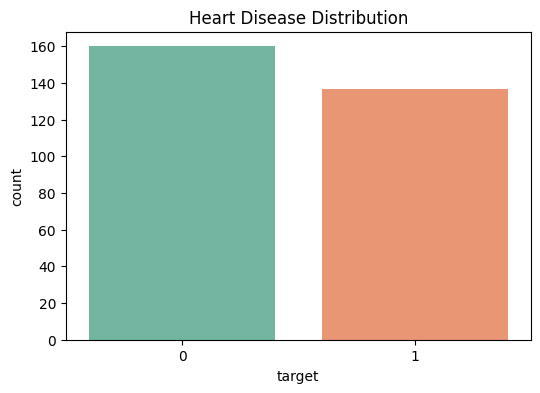

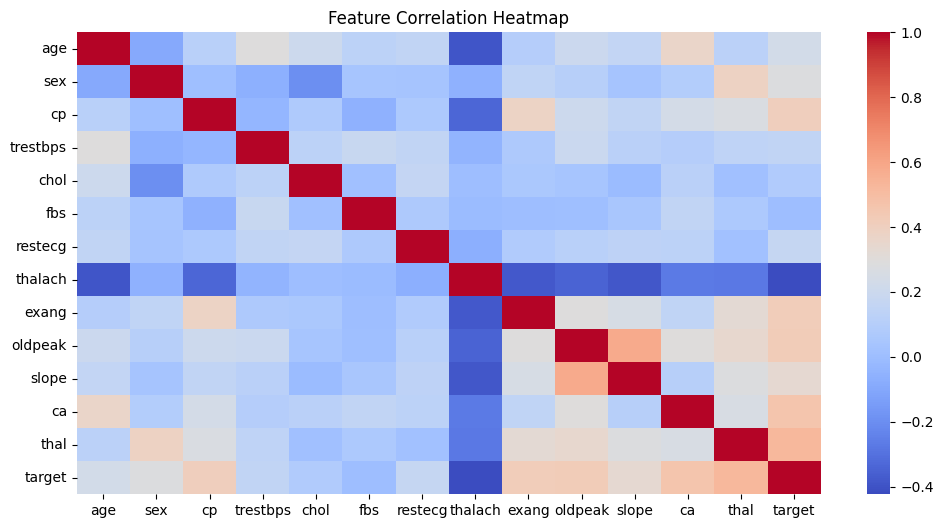

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'N', 'sex': 'N', 'cp': 'N', 'trestbps': 'N', 'chol': 'N', 'fbs': 'N', 'restecg': 'N', 'thalach': 'N', 'exang': 'N', 'oldpeak': 'N', 'slope': 'N', 'ca': 'N', 'thal': 'N', 'target': 'N', 'age_group': 'O', 'bp_category': 'O', 'chol_category': 'O', 'thalach_level': 'O'}


Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.71        49
           1       0.00      0.00      0.00        41

    accuracy                           0.54        90
   macro avg       0.27      0.50      0.35        90
weighted avg       0.30      0.54      0.38        90

Confusion Matrix:
[[49  0]
 [41  0]]


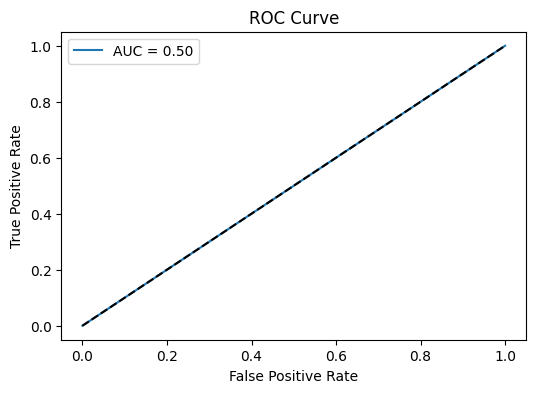

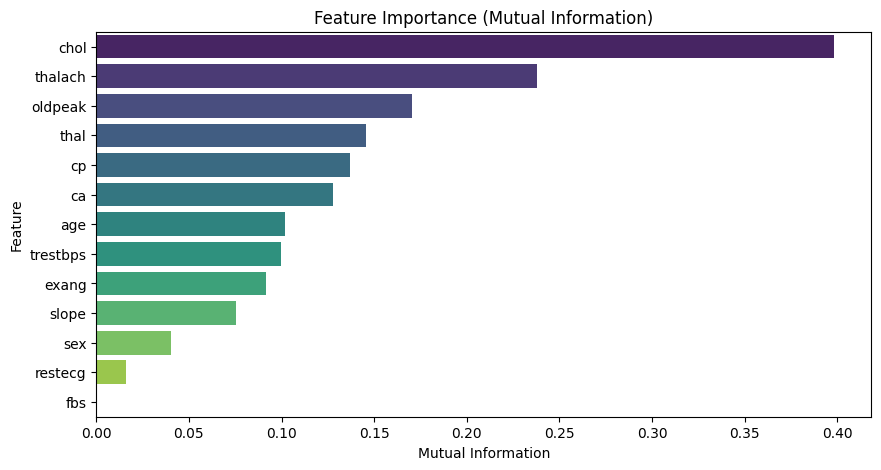

Medical Insights:
- Chest pain type 3 increases disease probability: 0.50
- High cholesterol increases disease probability: 0.50
- Older patients have higher disease probability: 0.50


In [3]:
bn = HeartDiseaseBayesianNetwork()

# Step 1: Load dataset
df = bn.download_dataset()

# Step 2: Explore
bn.explore_data(df)

# Step 3: Preprocess
df_processed = bn.preprocess_data(df)

# Step 4: Build & Train
bn.build_network()
bn.train_network(df_processed)

# Step 5: Evaluate
bn.evaluate_model(df_processed)

# Step 6: Feature Importance
bn.feature_importance()

# Step 7: Medical Insights
bn.generate_medical_insights()
